In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os
import csv
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm
from early_stopping_pytorch import EarlyStopping
import matplotlib.pyplot as plt

In [ ]:
# check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

from google.colab import drive
drive.mount('/content/drive')

#file path in google drive
data_dir = "/content/drive/MyDrive/data"

Using device: cpu
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Training model**

In [ ]:
# Define Transformations for train data

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), #adding more data
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), #petit valeur pour ne pas trop changer l'image
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.25),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define Transformation for validation and test data
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# data loading
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=test_transform)

# create DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

# display dataset information
print(f"Nombre d'images d'entraînement : {len(train_dataset)}")
print(f"Nombre d'images de validation : {len(val_dataset)}")
print(f"Nombre de classes dans train : {len(train_dataset.classes)}")
print(f"Nombre de classes dans val : {len(val_dataset.classes)}")

# path to data directory
data_dir = "/content/drive/MyDrive/data"


Nombre d'images d'entraînement : 20724
Nombre d'images de validation : 300
Nombre de classes dans train : 100
Nombre de classes dans val : 100


In [ ]:
# Loading ResNet-50 pretrained
model = models.resnet50(pretrained=True)

for name, param in model.named_parameters():
    if name.startswith("layer3") or name.startswith("layer4") or name.startswith("fc"):
        param.requires_grad = True
    else:
        param.requires_grad = False #on gèle les couches pour ne pas les modifier pendant l'entrainement, seule la dernière couche sera modifiée. Réduit le temps d'entrainement et évite le surapprentissage

# Modify the final layer to output predictions for 100 classes
num_classes = 100

model.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)

# check if GPU is available again
model = model.to(device)

# Define Loss function, optimizer and scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.15)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5, weight_decay=1e-4) #lr smaller to be more stable and progressively decrease it
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# adding earlystopping for improvement
early_stopping = EarlyStopping(patience=10, verbose=True)

# list created for curve plot
train_acc_list, val_acc_list, train_loss_list, val_loss_list = [], [], [], []

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 179MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

Train Epoch 1: 100%|██████████| 162/162 [01:52<00:00,  1.44it/s]


Epoch [1/50], Train Loss: 4.4733, Train Acc: 5.68%


Val Epoch 1: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


Epoch [1/50], Val Loss: 4.4123, Val Acc: 14.00%
Validation loss decreased (inf --> 4.412326).  Saving model ...
!! New best model saved (Val Acc: 14.00%)


Train Epoch 2: 100%|██████████| 162/162 [01:52<00:00,  1.44it/s]


Epoch [2/50], Train Loss: 3.9815, Train Acc: 22.11%


Val Epoch 2: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


Epoch [2/50], Val Loss: 4.0389, Val Acc: 17.67%
Validation loss decreased (4.412326 --> 4.038907).  Saving model ...
!! New best model saved (Val Acc: 17.67%)


Train Epoch 3: 100%|██████████| 162/162 [01:51<00:00,  1.45it/s]


Epoch [3/50], Train Loss: 3.4949, Train Acc: 34.21%


Val Epoch 3: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


Epoch [3/50], Val Loss: 3.7953, Val Acc: 23.67%
Validation loss decreased (4.038907 --> 3.795279).  Saving model ...
!! New best model saved (Val Acc: 23.67%)


Train Epoch 4: 100%|██████████| 162/162 [01:52<00:00,  1.44it/s]


Epoch [4/50], Train Loss: 3.1452, Train Acc: 42.19%


Val Epoch 4: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


Epoch [4/50], Val Loss: 3.5642, Val Acc: 27.00%
Validation loss decreased (3.795279 --> 3.564193).  Saving model ...
!! New best model saved (Val Acc: 27.00%)


Train Epoch 5: 100%|██████████| 162/162 [01:50<00:00,  1.46it/s]


Epoch [5/50], Train Loss: 2.9052, Train Acc: 47.63%


Val Epoch 5: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


Epoch [5/50], Val Loss: 3.3610, Val Acc: 30.67%
Validation loss decreased (3.564193 --> 3.361031).  Saving model ...
!! New best model saved (Val Acc: 30.67%)


Train Epoch 6: 100%|██████████| 162/162 [01:51<00:00,  1.45it/s]


Epoch [6/50], Train Loss: 2.7170, Train Acc: 52.68%


Val Epoch 6: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


Epoch [6/50], Val Loss: 3.1995, Val Acc: 35.67%
Validation loss decreased (3.361031 --> 3.199512).  Saving model ...
!! New best model saved (Val Acc: 35.67%)


Train Epoch 7: 100%|██████████| 162/162 [01:51<00:00,  1.45it/s]


Epoch [7/50], Train Loss: 2.5662, Train Acc: 56.94%


Val Epoch 7: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


Epoch [7/50], Val Loss: 3.0348, Val Acc: 39.33%
Validation loss decreased (3.199512 --> 3.034847).  Saving model ...
!! New best model saved (Val Acc: 39.33%)


Train Epoch 8: 100%|██████████| 162/162 [01:52<00:00,  1.45it/s]


Epoch [8/50], Train Loss: 2.4333, Train Acc: 60.61%


Val Epoch 8: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


Epoch [8/50], Val Loss: 2.9073, Val Acc: 42.67%
Validation loss decreased (3.034847 --> 2.907311).  Saving model ...
!! New best model saved (Val Acc: 42.67%)


Train Epoch 9: 100%|██████████| 162/162 [01:52<00:00,  1.44it/s]


Epoch [9/50], Train Loss: 2.3328, Train Acc: 63.18%


Val Epoch 9: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


Epoch [9/50], Val Loss: 2.7727, Val Acc: 44.67%
Validation loss decreased (2.907311 --> 2.772661).  Saving model ...
!! New best model saved (Val Acc: 44.67%)


Train Epoch 10: 100%|██████████| 162/162 [01:53<00:00,  1.43it/s]


Epoch [10/50], Train Loss: 2.2330, Train Acc: 66.24%


Val Epoch 10: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


Epoch [10/50], Val Loss: 2.6456, Val Acc: 48.67%
Validation loss decreased (2.772661 --> 2.645550).  Saving model ...
!! New best model saved (Val Acc: 48.67%)


Train Epoch 11: 100%|██████████| 162/162 [01:53<00:00,  1.43it/s]


Epoch [11/50], Train Loss: 2.1522, Train Acc: 68.86%


Val Epoch 11: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


Epoch [11/50], Val Loss: 2.5360, Val Acc: 50.00%
Validation loss decreased (2.645550 --> 2.535990).  Saving model ...
!! New best model saved (Val Acc: 50.00%)


Train Epoch 12: 100%|██████████| 162/162 [01:57<00:00,  1.38it/s]


Epoch [12/50], Train Loss: 2.0865, Train Acc: 70.62%


Val Epoch 12: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


Epoch [12/50], Val Loss: 2.4322, Val Acc: 53.67%
Validation loss decreased (2.535990 --> 2.432228).  Saving model ...
!! New best model saved (Val Acc: 53.67%)


Train Epoch 13: 100%|██████████| 162/162 [01:56<00:00,  1.39it/s]


Epoch [13/50], Train Loss: 2.0250, Train Acc: 72.53%


Val Epoch 13: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


Epoch [13/50], Val Loss: 2.3634, Val Acc: 54.00%
Validation loss decreased (2.432228 --> 2.363436).  Saving model ...
!! New best model saved (Val Acc: 54.00%)


Train Epoch 14: 100%|██████████| 162/162 [01:55<00:00,  1.40it/s]


Epoch [14/50], Train Loss: 1.9680, Train Acc: 74.46%


Val Epoch 14: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


Epoch [14/50], Val Loss: 2.2853, Val Acc: 58.00%
Validation loss decreased (2.363436 --> 2.285281).  Saving model ...
!! New best model saved (Val Acc: 58.00%)


Train Epoch 15: 100%|██████████| 162/162 [01:54<00:00,  1.41it/s]


Epoch [15/50], Train Loss: 1.9227, Train Acc: 76.07%


Val Epoch 15: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


Epoch [15/50], Val Loss: 2.2188, Val Acc: 62.00%
Validation loss decreased (2.285281 --> 2.218826).  Saving model ...
!! New best model saved (Val Acc: 62.00%)


Train Epoch 16: 100%|██████████| 162/162 [01:53<00:00,  1.43it/s]


Epoch [16/50], Train Loss: 1.8793, Train Acc: 77.36%


Val Epoch 16: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


Epoch [16/50], Val Loss: 2.1555, Val Acc: 66.33%
Validation loss decreased (2.218826 --> 2.155453).  Saving model ...
!! New best model saved (Val Acc: 66.33%)


Train Epoch 17: 100%|██████████| 162/162 [01:52<00:00,  1.44it/s]


Epoch [17/50], Train Loss: 1.8413, Train Acc: 78.50%


Val Epoch 17: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


Epoch [17/50], Val Loss: 2.1260, Val Acc: 65.33%
Validation loss decreased (2.155453 --> 2.126026).  Saving model ...


Train Epoch 18: 100%|██████████| 162/162 [01:53<00:00,  1.43it/s]


Epoch [18/50], Train Loss: 1.7971, Train Acc: 80.21%


Val Epoch 18: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


Epoch [18/50], Val Loss: 2.0784, Val Acc: 68.00%
Validation loss decreased (2.126026 --> 2.078379).  Saving model ...
!! New best model saved (Val Acc: 68.00%)


Train Epoch 19: 100%|██████████| 162/162 [01:52<00:00,  1.44it/s]


Epoch [19/50], Train Loss: 1.7694, Train Acc: 81.16%


Val Epoch 19: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


Epoch [19/50], Val Loss: 2.0266, Val Acc: 70.00%
Validation loss decreased (2.078379 --> 2.026624).  Saving model ...
!! New best model saved (Val Acc: 70.00%)


Train Epoch 20: 100%|██████████| 162/162 [01:52<00:00,  1.45it/s]


Epoch [20/50], Train Loss: 1.7461, Train Acc: 81.94%


Val Epoch 20: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


Epoch [20/50], Val Loss: 2.0036, Val Acc: 70.33%
Validation loss decreased (2.026624 --> 2.003581).  Saving model ...
!! New best model saved (Val Acc: 70.33%)


Train Epoch 21: 100%|██████████| 162/162 [01:53<00:00,  1.43it/s]


Epoch [21/50], Train Loss: 1.7200, Train Acc: 82.72%


Val Epoch 21: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


Epoch [21/50], Val Loss: 1.9641, Val Acc: 72.33%
Validation loss decreased (2.003581 --> 1.964079).  Saving model ...
!! New best model saved (Val Acc: 72.33%)


Train Epoch 22: 100%|██████████| 162/162 [01:52<00:00,  1.44it/s]


Epoch [22/50], Train Loss: 1.6892, Train Acc: 84.20%


Val Epoch 22: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


Epoch [22/50], Val Loss: 1.9294, Val Acc: 73.67%
Validation loss decreased (1.964079 --> 1.929368).  Saving model ...
!! New best model saved (Val Acc: 73.67%)


Train Epoch 23: 100%|██████████| 162/162 [01:53<00:00,  1.42it/s]


Epoch [23/50], Train Loss: 1.6685, Train Acc: 84.80%


Val Epoch 23: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


Epoch [23/50], Val Loss: 1.9263, Val Acc: 73.00%
Validation loss decreased (1.929368 --> 1.926340).  Saving model ...


Train Epoch 24: 100%|██████████| 162/162 [01:53<00:00,  1.43it/s]


Epoch [24/50], Train Loss: 1.6480, Train Acc: 85.16%


Val Epoch 24: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


Epoch [24/50], Val Loss: 1.8872, Val Acc: 75.00%
Validation loss decreased (1.926340 --> 1.887167).  Saving model ...
!! New best model saved (Val Acc: 75.00%)


Train Epoch 25: 100%|██████████| 162/162 [01:52<00:00,  1.43it/s]


Epoch [25/50], Train Loss: 1.6287, Train Acc: 86.11%


Val Epoch 25: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


Epoch [25/50], Val Loss: 1.8691, Val Acc: 74.00%
Validation loss decreased (1.887167 --> 1.869072).  Saving model ...


Train Epoch 26: 100%|██████████| 162/162 [01:52<00:00,  1.44it/s]


Epoch [26/50], Train Loss: 1.6188, Train Acc: 86.27%


Val Epoch 26: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


Epoch [26/50], Val Loss: 1.8882, Val Acc: 74.33%
EarlyStopping counter: 1 out of 10


Train Epoch 27: 100%|██████████| 162/162 [01:52<00:00,  1.44it/s]


Epoch [27/50], Train Loss: 1.5942, Train Acc: 87.01%


Val Epoch 27: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]


Epoch [27/50], Val Loss: 1.8570, Val Acc: 75.00%
Validation loss decreased (1.869072 --> 1.856977).  Saving model ...


Train Epoch 28: 100%|██████████| 162/162 [01:52<00:00,  1.44it/s]


Epoch [28/50], Train Loss: 1.5786, Train Acc: 87.57%


Val Epoch 28: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


Epoch [28/50], Val Loss: 1.8428, Val Acc: 77.33%
Validation loss decreased (1.856977 --> 1.842802).  Saving model ...
!! New best model saved (Val Acc: 77.33%)


Train Epoch 29: 100%|██████████| 162/162 [01:52<00:00,  1.44it/s]


Epoch [29/50], Train Loss: 1.5684, Train Acc: 87.99%


Val Epoch 29: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


Epoch [29/50], Val Loss: 1.8364, Val Acc: 76.33%
Validation loss decreased (1.842802 --> 1.836444).  Saving model ...


Train Epoch 30: 100%|██████████| 162/162 [01:52<00:00,  1.44it/s]


Epoch [30/50], Train Loss: 1.5550, Train Acc: 88.25%


Val Epoch 30: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


Epoch [30/50], Val Loss: 1.8276, Val Acc: 76.33%
Validation loss decreased (1.836444 --> 1.827553).  Saving model ...


Train Epoch 31: 100%|██████████| 162/162 [01:52<00:00,  1.44it/s]


Epoch [31/50], Train Loss: 1.5399, Train Acc: 88.89%


Val Epoch 31: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


Epoch [31/50], Val Loss: 1.7991, Val Acc: 77.67%
Validation loss decreased (1.827553 --> 1.799086).  Saving model ...
!! New best model saved (Val Acc: 77.67%)


Train Epoch 32: 100%|██████████| 162/162 [01:51<00:00,  1.45it/s]


Epoch [32/50], Train Loss: 1.5313, Train Acc: 88.91%


Val Epoch 32: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


Epoch [32/50], Val Loss: 1.7990, Val Acc: 77.00%
Validation loss decreased (1.799086 --> 1.799028).  Saving model ...


Train Epoch 33: 100%|██████████| 162/162 [01:51<00:00,  1.45it/s]


Epoch [33/50], Train Loss: 1.5150, Train Acc: 89.67%


Val Epoch 33: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


Epoch [33/50], Val Loss: 1.7978, Val Acc: 77.33%
Validation loss decreased (1.799028 --> 1.797770).  Saving model ...


Train Epoch 34: 100%|██████████| 162/162 [01:51<00:00,  1.45it/s]


Epoch [34/50], Train Loss: 1.5023, Train Acc: 89.98%


Val Epoch 34: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


Epoch [34/50], Val Loss: 1.8147, Val Acc: 77.67%
EarlyStopping counter: 1 out of 10


Train Epoch 35: 100%|██████████| 162/162 [01:52<00:00,  1.45it/s]


Epoch [35/50], Train Loss: 1.4941, Train Acc: 90.40%


Val Epoch 35: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


Epoch [35/50], Val Loss: 1.7818, Val Acc: 78.67%
Validation loss decreased (1.797770 --> 1.781797).  Saving model ...
!! New best model saved (Val Acc: 78.67%)


Train Epoch 36: 100%|██████████| 162/162 [01:52<00:00,  1.44it/s]


Epoch [36/50], Train Loss: 1.4820, Train Acc: 90.76%


Val Epoch 36: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


Epoch [36/50], Val Loss: 1.7914, Val Acc: 78.33%
EarlyStopping counter: 1 out of 10


Train Epoch 37: 100%|██████████| 162/162 [01:53<00:00,  1.43it/s]


Epoch [37/50], Train Loss: 1.4739, Train Acc: 91.03%


Val Epoch 37: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


Epoch [37/50], Val Loss: 1.7932, Val Acc: 78.33%
EarlyStopping counter: 2 out of 10


Train Epoch 38: 100%|██████████| 162/162 [01:53<00:00,  1.42it/s]


Epoch [38/50], Train Loss: 1.4573, Train Acc: 91.67%


Val Epoch 38: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


Epoch [38/50], Val Loss: 1.7675, Val Acc: 79.33%
Validation loss decreased (1.781797 --> 1.767538).  Saving model ...
!! New best model saved (Val Acc: 79.33%)


Train Epoch 39: 100%|██████████| 162/162 [01:53<00:00,  1.43it/s]


Epoch [39/50], Train Loss: 1.4560, Train Acc: 91.54%


Val Epoch 39: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


Epoch [39/50], Val Loss: 1.7612, Val Acc: 81.33%
Validation loss decreased (1.767538 --> 1.761159).  Saving model ...
!! New best model saved (Val Acc: 81.33%)


Train Epoch 40: 100%|██████████| 162/162 [01:53<00:00,  1.43it/s]


Epoch [40/50], Train Loss: 1.4483, Train Acc: 91.86%


Val Epoch 40: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


Epoch [40/50], Val Loss: 1.7543, Val Acc: 79.67%
Validation loss decreased (1.761159 --> 1.754336).  Saving model ...


Train Epoch 41: 100%|██████████| 162/162 [01:52<00:00,  1.44it/s]


Epoch [41/50], Train Loss: 1.4357, Train Acc: 92.18%


Val Epoch 41: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


Epoch [41/50], Val Loss: 1.7459, Val Acc: 79.67%
Validation loss decreased (1.754336 --> 1.745916).  Saving model ...


Train Epoch 42: 100%|██████████| 162/162 [01:53<00:00,  1.43it/s]


Epoch [42/50], Train Loss: 1.4354, Train Acc: 92.09%


Val Epoch 42: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


Epoch [42/50], Val Loss: 1.7297, Val Acc: 81.67%
Validation loss decreased (1.745916 --> 1.729708).  Saving model ...
!! New best model saved (Val Acc: 81.67%)


Train Epoch 43: 100%|██████████| 162/162 [01:53<00:00,  1.43it/s]


Epoch [43/50], Train Loss: 1.4269, Train Acc: 92.52%


Val Epoch 43: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


Epoch [43/50], Val Loss: 1.7315, Val Acc: 80.67%
EarlyStopping counter: 1 out of 10


Train Epoch 44: 100%|██████████| 162/162 [01:53<00:00,  1.42it/s]


Epoch [44/50], Train Loss: 1.4165, Train Acc: 92.88%


Val Epoch 44: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


Epoch [44/50], Val Loss: 1.7214, Val Acc: 81.00%
Validation loss decreased (1.729708 --> 1.721428).  Saving model ...


Train Epoch 45: 100%|██████████| 162/162 [01:52<00:00,  1.43it/s]


Epoch [45/50], Train Loss: 1.4016, Train Acc: 93.37%


Val Epoch 45: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


Epoch [45/50], Val Loss: 1.7243, Val Acc: 80.67%
EarlyStopping counter: 1 out of 10


Train Epoch 46: 100%|██████████| 162/162 [01:52<00:00,  1.44it/s]


Epoch [46/50], Train Loss: 1.4061, Train Acc: 93.14%


Val Epoch 46: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


Epoch [46/50], Val Loss: 1.7250, Val Acc: 81.67%
EarlyStopping counter: 2 out of 10


Train Epoch 47: 100%|██████████| 162/162 [01:54<00:00,  1.42it/s]


Epoch [47/50], Train Loss: 1.3975, Train Acc: 93.38%


Val Epoch 47: 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]


Epoch [47/50], Val Loss: 1.7069, Val Acc: 83.00%
Validation loss decreased (1.721428 --> 1.706874).  Saving model ...
!! New best model saved (Val Acc: 83.00%)


Train Epoch 48: 100%|██████████| 162/162 [01:54<00:00,  1.41it/s]


Epoch [48/50], Train Loss: 1.3918, Train Acc: 93.56%


Val Epoch 48: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


Epoch [48/50], Val Loss: 1.7145, Val Acc: 82.67%
EarlyStopping counter: 1 out of 10


Train Epoch 49: 100%|██████████| 162/162 [01:53<00:00,  1.42it/s]


Epoch [49/50], Train Loss: 1.3827, Train Acc: 93.90%


Val Epoch 49: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


Epoch [49/50], Val Loss: 1.7207, Val Acc: 81.67%
EarlyStopping counter: 2 out of 10


Train Epoch 50: 100%|██████████| 162/162 [01:54<00:00,  1.41it/s]


Epoch [50/50], Train Loss: 1.3785, Train Acc: 94.15%


Val Epoch 50: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


Epoch [50/50], Val Loss: 1.6983, Val Acc: 82.67%
Validation loss decreased (1.706874 --> 1.698258).  Saving model ...
Model sauved in : resnet50_modelV3.pth


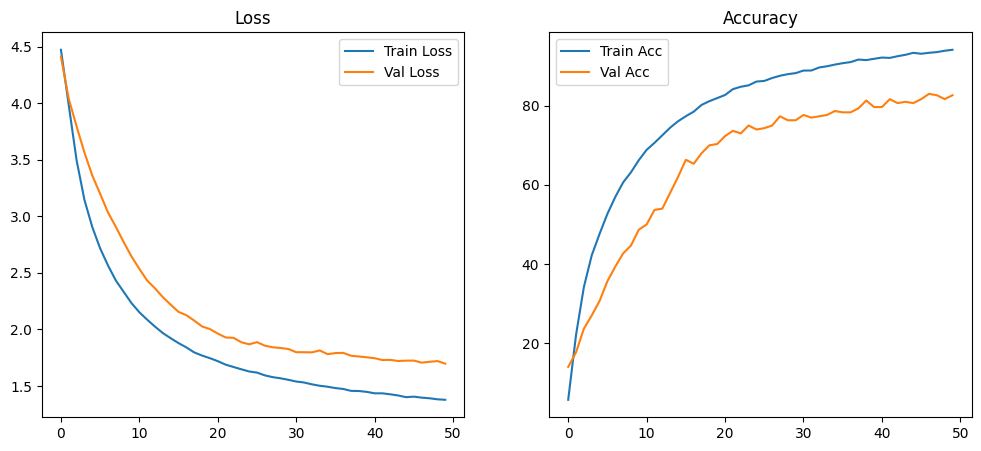

In [ ]:
# define training model with validation
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50):
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")

        # Validation part
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Val Epoch {epoch+1}"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100. * val_correct / val_total
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
        print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # early stopping to stop running when no more improvement
        scheduler.step(val_loss)
        early_stopping(val_loss, model)

        # save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_modelV3.pth')
            print(f"!! New best model saved (Val Acc: {val_acc:.2f}%)")

        # 
        if early_stopping.early_stop:
            print("Early stopping declenched !")
            break

# training start...
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50)

# save final result
model_save_path = 'resnet50_modelV3.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model sauved in : {model_save_path}")

# Plot training curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list, label='Val Acc')
plt.title("Accuracy")
plt.legend()
plt.show()

In [ ]:
# Test the model trained
# Define a class to load test data
class CustomTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [os.path.join(root_dir, f) for f in os.listdir(root_dir)
                            if f.endswith(('.jpg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        file_name = os.path.basename(img_path)
        return image, file_name

# Loading test file data
test_dir = os.path.join(data_dir, 'test')  # Assure-toi que data_dir est défini
test_dataset = CustomTestDataset(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'))
class_to_idx = train_dataset.class_to_idx
idx_to_classname = {v: k for k, v in class_to_idx.items()}


# create the same model as training mode
model = models.resnet50(pretrained=False)
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.4),
    torch.nn.Linear(2048, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(512, 100)
)

# laoding the model trained
model.load_state_dict(torch.load("resnet50_modelV3.pth", map_location=device))
model = model.to(device)
model.eval()

# Predictions
predictions = []

with torch.no_grad():
    for inputs, file_names in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        predicted = predicted.cpu().numpy()

        for file_name, pred in zip(file_names, predicted):
            true_label = idx_to_classname[pred]  # label sous forme de string (ex: '13')
            predictions.append((file_name, true_label))

# Save the prediction in a CSV file
with open("predictionV3-3.csv", "w", newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["file_name", "predicted_class"])
    for file_name, pred in predictions:
        writer.writerow([file_name, pred])

print("Prédictions sauvegardées dans 'predictionV3-3.csv'")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Prédictions sauvegardées dans 'predictionV3-3.csv'


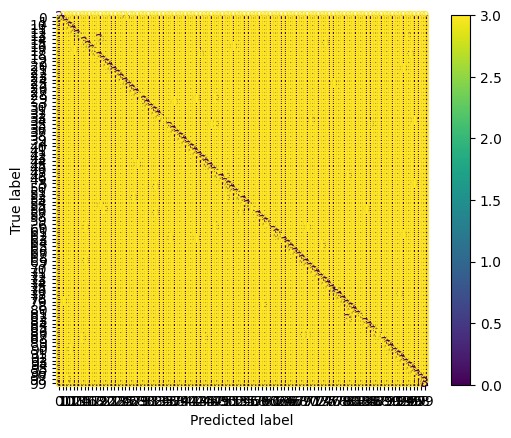

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=train_dataset.classes).plot()
plt.show()
